# Electricity price comparation

The purpose of this notebook is to compare different price options that the electricity company offers. In fact, that's my electricity consumption and for a long time I believed that my electricity plan included a free of charge day a week. After reviewing the contract, I found I was wrong.

I have thought that it could be a good data analysis practice. There are a few little objectives to achieve in this way:

<ol>
    <li>Load the data.</li>
    <li>Find if there is a moment in time where my personal habits reflect the assumption of a free of charge day a week.</li>
    <li>Compare plans with the different habits and conclude which is better for my pocket.</li>
</ol>

In [532]:
using DataFrames, CSV, Plots, Dates

## Load data

Data is stored in different CSV files in the "data" directory. We're going to take all the files and create a DataFrame with all the entries.

In [533]:
raw_data = readdir("./data")
df = DataFrame()

for file in raw_data
    df_ = CSV.File("./data/" * file) |> DataFrame
    df = vcat(df, df_)
end

rename!(df, :Fecha => :Date)
rename!(df, :Hora => :Hour)
rename!(df, :AE_kWh => :kwh)
df.kwh = parse.(Float64, replace.(df.kwh, "," => "."))

first(df, 5)

Row,Date,Hour,kwh
,String15,Int64,Float64
1,09/11/2022,1,0.094
2,09/11/2022,2,0.092
3,09/11/2022,3,0.088
4,09/11/2022,4,0.088
5,09/11/2022,5,0.041


### Making some adjusts

If we take a look to the data, we find that at the moment to changing to summer time, there is a problem with some days of the year. We find that the maximum for the "Hour" column is 25. That can be a problem when we collapse this data into a DateTime object. Note that the hour _x_ indicates the consumption made between _x-1_ and _x_. 

In [534]:
describe(df.Hour)

Summary Stats:
Length:         14567
Missing Count:  0
Mean:           12.499279
Std. Deviation: 6.922125
Minimum:        1.000000
1st Quartile:   6.500000
Median:         12.000000
3rd Quartile:   18.000000
Maximum:        25.000000
Type:           Int64


To avoid the problem, we are going to find the days where the time change occurs and:
<ul>
    <li>for days where 3am becomes 2am, we are going to take the 3rd hour and sum it up with the 2nd hour, as we want to calculate the electricity rate depending on the time. For the rest of the hours beyond 3am we will make a shift one position to the left, subtracting one hour.</li>
    <li>for days where 2am becomes 3am, we are going to shift the 2nd hour and beyond one position to the right, adding one hour.</li>
</ul>

The following code find the days that have 25 hours and modiofies them as we have already explained:

In [535]:
df_groupby_date = groupby(df, :Date)
summer_add_dates = filter(:Hour_maximum => col -> col == 25, combine(df_groupby_date, :Hour => maximum)).Date

1-element Vector{String15}:
 "29/10/2023"

In [536]:
df_summer_add_dates = [g for g in df_groupby_date if g.Date[1] in summer_add_dates]
first(df_summer_add_dates[1], 6)

Row,Date,Hour,kwh
,String15,Int64,Float64
1,29/10/2023,1,0.15
2,29/10/2023,2,0.128
3,29/10/2023,3,0.084
4,29/10/2023,4,0.082
5,29/10/2023,5,0.077
6,29/10/2023,6,0.055


In [537]:
for df_ in df_summer_add_dates
    df_.kwh[2] += df_.kwh[3]
    for i in 3:24
        df_.kwh[i] = df_.kwh[i+1]
    end
    delete!(df, last(indexin(eachrow(df_), eachrow(df))))
end

In [538]:
first(df_summer_add_dates[1], 6)

Row,Date,Hour,kwh
,String15,Int64,Float64
1,29/10/2023,1,0.15
2,29/10/2023,2,0.212
3,29/10/2023,3,0.082
4,29/10/2023,4,0.077
5,29/10/2023,5,0.055
6,29/10/2023,6,0.083


Now, we are going to analyze the days where an hour is missing. We ensures our assumption: that there are days with only 23 entries.

In [539]:
df_groupby_date = groupby(df, :Date) # to avoid redimension errors from a SubDataFrame
describe(combine(df_groupby_date, nrow => :group_size))

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Date,,01/01/2023,,31/12/2023,0,String15
2,group_size,23.9967,23,24.0,24,0,Int64


Now, let's modify them:

In [540]:
df_groupby_date = groupby(df, :Date)
summer_subs_dates = filter(:group_size => col -> col == 23, combine(df_groupby_date, nrow => :group_size)).Date

2-element Vector{String15}:
 "26/03/2023"
 "31/03/2024"

In [541]:
df_summer_subs_dates = [g for g in df_groupby_date if g.Date[1] in summer_subs_dates]
println(first(df_summer_subs_dates[1], 4))
last(df_summer_subs_dates[1], 3)

4×3 DataFrame
 Row │ Date        Hour   kwh     
     │ String15    Int64  Float64 
─────┼────────────────────────────
   1 │ 26/03/2023      1    0.14
   2 │ 26/03/2023      2    0.149
   3 │ 26/03/2023      3    0.115
   4 │ 26/03/2023      4    0.113


Row,Date,Hour,kwh
,String15,Int64,Float64
1,26/03/2023,21,1.008
2,26/03/2023,22,0.482
3,26/03/2023,23,1.699


In [542]:
for df_ in df_summer_subs_dates
    for i in 3:23
        df_.Hour[i] += 1
    end
end

println(first(df_summer_subs_dates[1], 4))
last(df_summer_subs_dates[1], 3)

4×3 DataFrame
 Row │ Date        Hour   kwh     
     │ String15    Int64  Float64 
─────┼────────────────────────────
   1 │ 26/03/2023      1    0.14
   2 │ 26/03/2023      2    0.149
   3 │ 26/03/2023      4    0.115
   4 │ 26/03/2023      5    0.113


Row,Date,Hour,kwh
,String15,Int64,Float64
1,26/03/2023,22,1.008
2,26/03/2023,23,0.482
3,26/03/2023,24,1.699


In [543]:
first(df, 25)

Row,Date,Hour,kwh
,String15,Int64,Float64
1,09/11/2022,1,0.094
2,09/11/2022,2,0.092
3,09/11/2022,3,0.088
4,09/11/2022,4,0.088
5,09/11/2022,5,0.041
6,09/11/2022,6,0.083
7,09/11/2022,7,0.088
8,09/11/2022,8,0.036
9,09/11/2022,9,0.6


In [544]:
df.Hour = string.(df.Hour)
df.Hour = ":" .* df.Hour
df.DateTime = join.(eachrow(df[:,["Date", "Hour"]]))
format = dateformat"dd/mm/yyyyy:HH"
df.DateTime = DateTime.(df.DateTime, format)
df = df[:, ["Date", "DateTime", "kwh"]]
df.DayOfTheWeek = Dates.dayofweek.(df.DateTime);

In [545]:
first(df, 25)

Row,Date,DateTime,kwh,DayOfTheWeek
,String15,DateTime,Float64,Int64
1,09/11/2022,2022-11-09T01:00:00,0.094,3
2,09/11/2022,2022-11-09T02:00:00,0.092,3
3,09/11/2022,2022-11-09T03:00:00,0.088,3
4,09/11/2022,2022-11-09T04:00:00,0.088,3
5,09/11/2022,2022-11-09T05:00:00,0.041,3
6,09/11/2022,2022-11-09T06:00:00,0.083,3
7,09/11/2022,2022-11-09T07:00:00,0.088,3
8,09/11/2022,2022-11-09T08:00:00,0.036,3
9,09/11/2022,2022-11-09T09:00:00,0.6,3


As you can see, we have to deal with another problem. The hour 24 has been converted to the first hour of the next day. Technically thats's correct, but since the consumption occurs between hours 23 and 24 on the previous day, and it may apply a different rate. We have to change the meaning of DateTime column to ensure data consistency. The best option is to subtract an hour for each entry and understand the DateTime column as the lower bound of the hour range.

In [546]:
df.DateTime .+= Hour(-1)
df.DayOfTheWeek = Dates.dayofweek.(df.DateTime);
first(df, 25)

Row,Date,DateTime,kwh,DayOfTheWeek
,String15,DateTime,Float64,Int64
1,09/11/2022,2022-11-09T00:00:00,0.094,3
2,09/11/2022,2022-11-09T01:00:00,0.092,3
3,09/11/2022,2022-11-09T02:00:00,0.088,3
4,09/11/2022,2022-11-09T03:00:00,0.088,3
5,09/11/2022,2022-11-09T04:00:00,0.041,3
6,09/11/2022,2022-11-09T05:00:00,0.083,3
7,09/11/2022,2022-11-09T06:00:00,0.088,3
8,09/11/2022,2022-11-09T07:00:00,0.036,3
9,09/11/2022,2022-11-09T08:00:00,0.6,3


And finally, let's some plot:

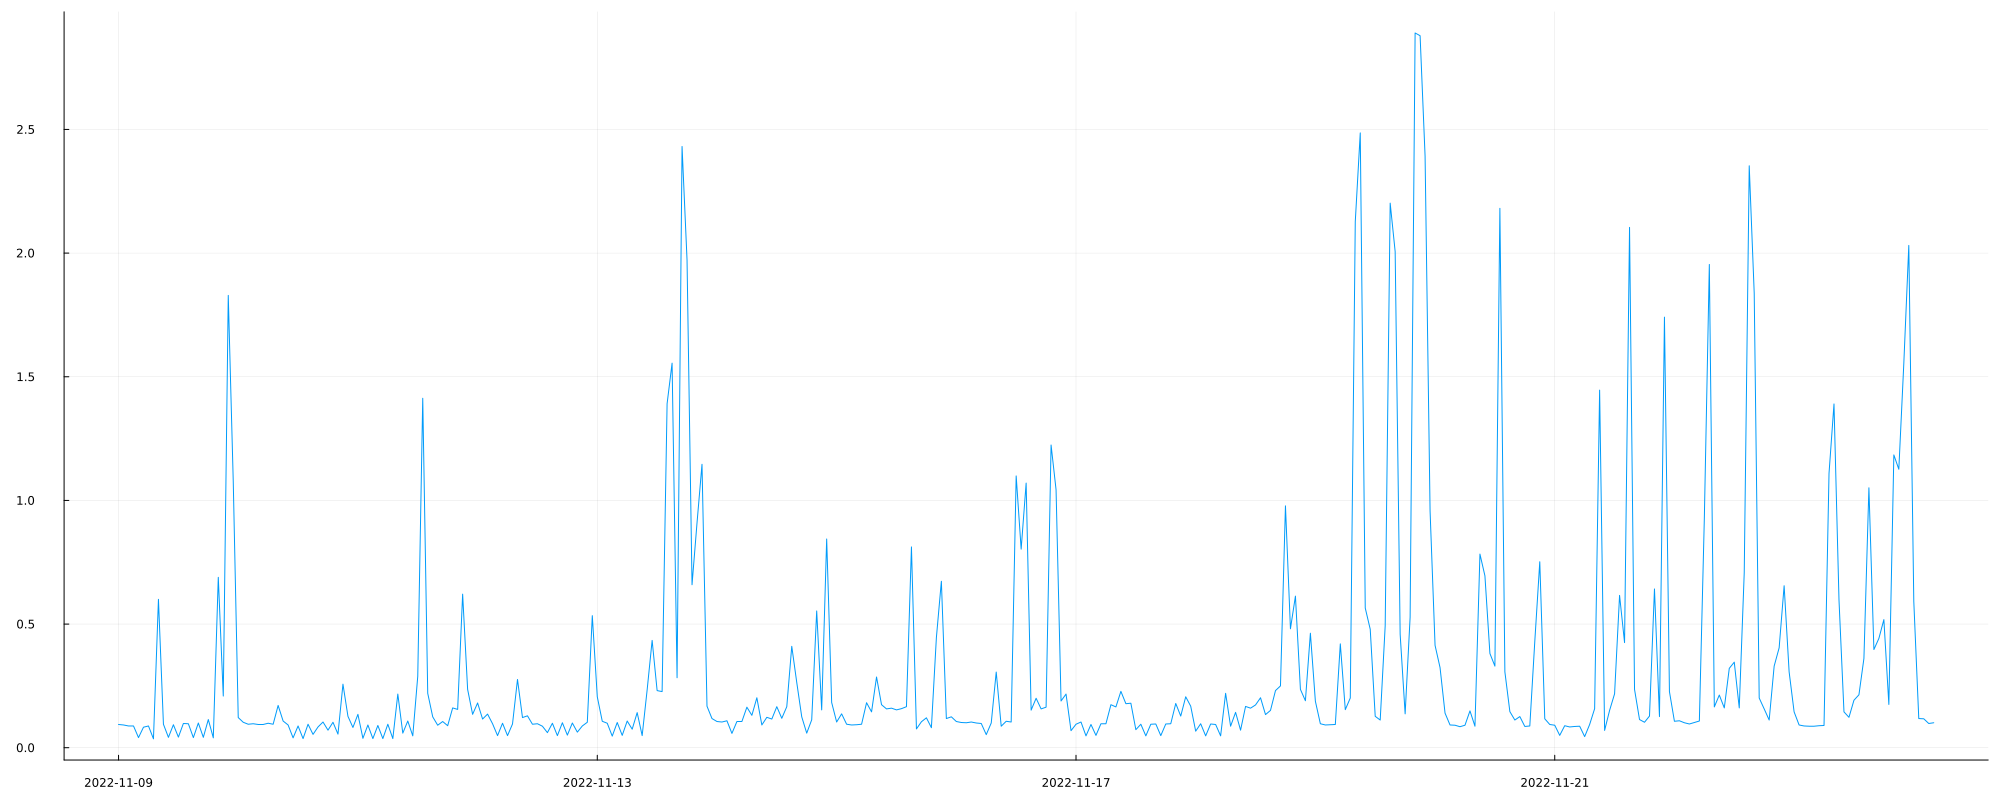

In [547]:
plot(df.DateTime[1:365], df.kwh[1:365], xlabel="date-time", ylabel="kWh", label=false, size=(2000, 800))

## Find the gap

As mentioned before, once upon a time I believed that a free of charge day rate was applied, but it was not. After that, I changed my consumption habits, i.e. I do more laundry, I use more the oven, etc., any day of the week. This day was Saturday, so I expect to see a variation in consumption of this day over time.

In [549]:
df_saturdays = groupby(groupby(df, :DayOfTheWeek)[6], :Date)

Row,Date,DateTime,kwh,DayOfTheWeek
,String15,DateTime,Float64,Int64
1,12/11/2022,2022-11-12T00:00:00,0.181,6
2,12/11/2022,2022-11-12T01:00:00,0.116,6
3,12/11/2022,2022-11-12T02:00:00,0.136,6
4,12/11/2022,2022-11-12T03:00:00,0.097,6
5,12/11/2022,2022-11-12T04:00:00,0.049,6
6,12/11/2022,2022-11-12T05:00:00,0.099,6
7,12/11/2022,2022-11-12T06:00:00,0.049,6
8,12/11/2022,2022-11-12T07:00:00,0.096,6
9,12/11/2022,2022-11-12T08:00:00,0.276,6


In [567]:
df_saturdays_consumption = combine(df_saturdays, :kwh .=> sum)

Row,Date,kwh_sum
,String15,Float64
1,12/11/2022,2.878
2,19/11/2022,22.179
3,26/11/2022,34.728
4,03/12/2022,52.627
5,10/12/2022,30.323
6,17/12/2022,33.82
7,24/12/2022,8.789
8,31/12/2022,24.345
9,07/01/2023,45.589


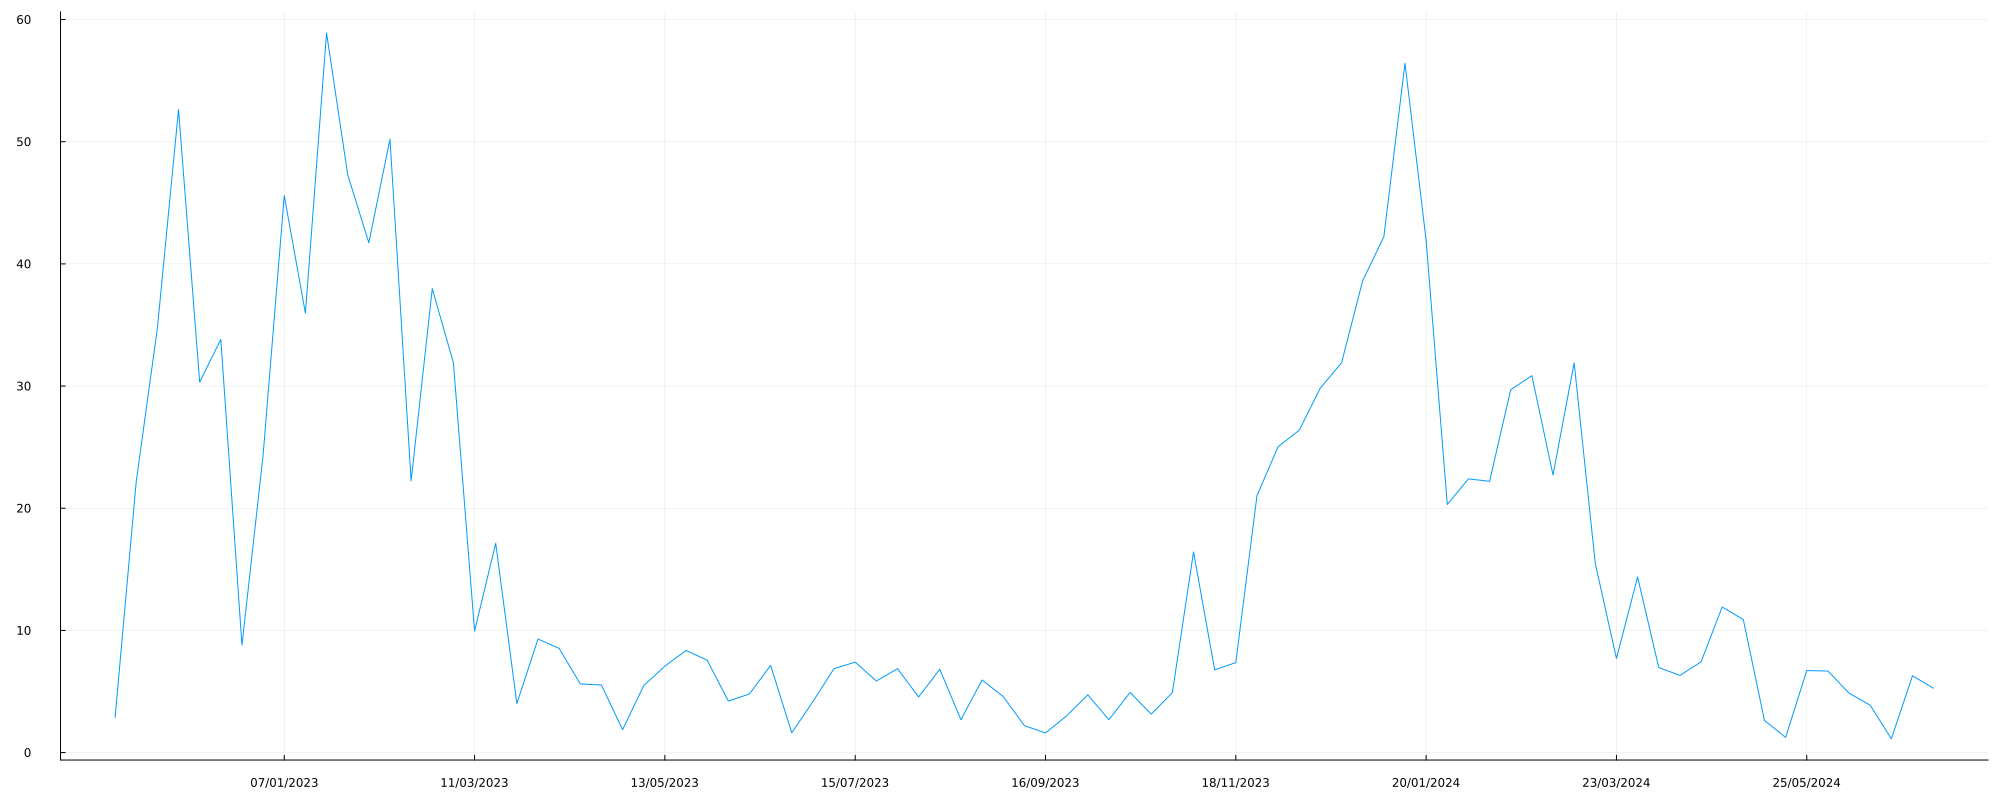

In [571]:
plot(df_saturdays_consumption.Date, df_saturdays_consumption.kwh_sum, xlabel="date", ylabel="kWh", label=false, size=(2000, 800))

In a first view, we can think that around 20/01/2024 there is a sudden change. To confirm that, I can think of two strategies:

<ul>
    <li>Compare Saturdays between years. As we can see, there are differences in the electricity consumption between winter and summer.</li>
    <li>Compare electricity consumption between different days of the week.</li>
</ul>

### Comparison over the year